In [13]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import networkx as nx
import pandas as pd

## Model 

In [5]:
def edge_degree(G,edge): 
    return G.degree[edge[0]]+G.degree[edge[1]]

def add_random_links(G,m): # generate m links between randomly chosen pairs of nodes in graph G and add them to G
    # return the list of generated links
    e,edges=0,[]
    N=G.number_of_nodes()
    while(e<m):
        d=np.random.choice(N,size=2,replace=False)
        if(not G.has_edge(d[0],d[1])):
            G.add_edge(d[0],d[1])
            edges.append((d[0],d[1]))
            e=e+1
    return edges

In [109]:
def clique_model(n,m,c,l=20,p0=0.2): # 2m is the number of triangular links, c - the number of random links
    MG=nx.erdos_renyi_graph(l,p0) # initial small random graph
    nodes=list(MG.nodes())
    edges=list(MG.edges()) # for target links
    e_degs=[edge_degree(MG,e) for e in edges]
    source=l # new node
    while source<n:
        probs=np.array(e_degs)/sum(e_degs)
        target_indices=np.random.choice(len(edges), size=m, replace=False, p=probs)
        target_nodes=set([edges[i][0] for i in target_indices]+[edges[i][1] for i in target_indices])# for pref attachment
        new_edges=list(zip([source]*len(target_nodes),target_nodes))

        MG.add_edges_from(new_edges)
        r_edges=new_random_links(MG,c) # add c links randomly
        edges=edges+new_edges+r_edges

        # recalculated probabilities  
        e_degs=[edge_degree(MG,e) for e in edges]
        
        source=source+1
    return MG

## Structural properties of simulated networks 

In [93]:
sizes=np.linspace(2000,8000,4, dtype=int) 
graphs=[clique_model(n,4,4) for n in sizes] 

In [94]:
def critical_probs(G):
    p1=1/G.number_of_nodes() # for link percolation
    p2=1/(np.sqrt(2*G.number_of_nodes()))
    return [p1,p2]

In [95]:
df = pd.DataFrame(columns=['Nodes', 'Edges', 'Density','Transitivity','Clustering','p_c(2)','p_c(3)'])

df['Nodes']=[nx.number_of_nodes(graph) for graph in graphs]
df['Edges']=[nx.number_of_edges(graph) for graph in graphs]
df['Density']=[nx.density(graph) for graph in graphs]
df['Transitivity']=[nx.transitivity(graph) for graph in graphs]
df['Clustering']=[nx.average_clustering(graph) for graph in graphs]

df['p_c(2)']=np.array([critical_probs(graph) for graph in graphs])[:,0]
df['p_c(3)']=np.array([critical_probs(graph) for graph in graphs])[:,1]

In [96]:
display(df)

,Nodes,Edges,Density,Transitivity,Clustering,p_c(2),p_c(3)
0,2000,23493,0.011752,0.056076,0.152449,0.000500,0.015811
1,4000,47099,0.005889,0.031307,0.141010,0.000250,0.011180
2,6000,69342,0.003853,0.015980,0.162878,0.000167,0.009129
3,8000,90880,0.002840,0.010652,0.175793,0.000125,0.007906


## Degree distribution and k-clique percolation in simulated networks

In [17]:
from networkx.algorithms.community import k_clique_communities

def max_clique_communities(G, k=3):# return the maximal size (number of nodes) of k-clique community, G is undirected graph
    if (k==2): 
        return len(max(nx.connected_components(G), key=len))
    else:
        c = list(k_clique_communities(G, k))
        if (len(c)==0):
            return 0
        else:
            return max([len(x) for x in c])

def clique_communities_enumerate(G,k_list): #return the list of clique community size for different k in k_list
    return np.array([max_clique_communities(G, k=k) for k in k_list])/G.number_of_nodes()

In [97]:
degrees=[] # for degree distribution 
for graph in graphs:
    degrees.append([d for n, d in graph.degree()])

In [98]:
y,x=np.histogram(degrees[0],bins=100)   # for powerlaw fit
x_=(x[1:]+x[:-1])/2
a,b=np.polyfit(np.log(x_[:-2]),np.log(1-np.cumsum(y)/graphs[0].number_of_nodes())[:-2],1)
print(a,b)

-1.7072309209060923 3.942555693570661


C:\Users\Olga\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [116]:
k_values=np.linspace(2,12,11, dtype=int)
cliqs=np.zeros([len(graphs),len(k_values)]) # 

for i in range(len(graphs)):
    cliqs[i,:]=clique_communities_enumerate(graphs[i],k_values)

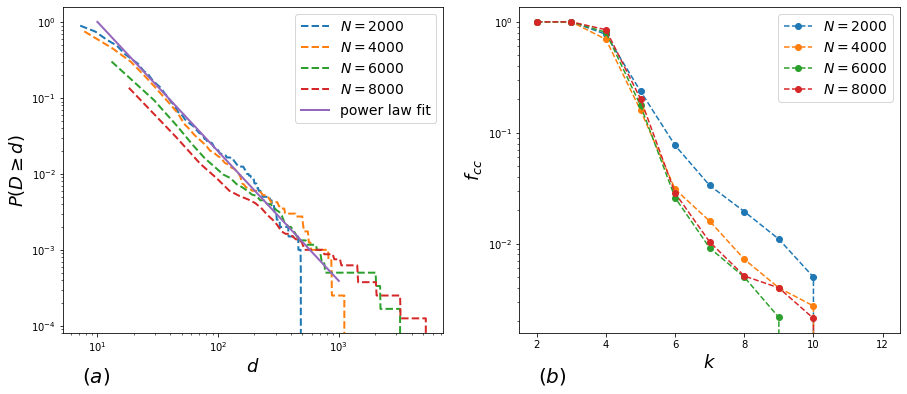

In [131]:
fig, ax = plt.subplots(nrows=1, sharex=False,sharey=False,ncols=2, figsize=(15, 6))

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_ylabel(r'$P(D\geq d)$', fontsize=18)
ax[0].set_xlabel(r'$d$', fontsize=18)

for i in range(len(graphs)):
    y,x=np.histogram(degrees[i],bins=200)
    x_=(x[1:]+x[:-1])/2
    ax[0].plot(x_,1-np.cumsum(y)/graphs[i].number_of_nodes(),'--',linewidth=2,label=r'$N=$'+str(graphs[i].number_of_nodes()))
    ax[1].plot(k_values,cliqs[i],'o--',label=r'$N=$'+str(graphs[i].number_of_nodes()))
    
x_=np.linspace(10,1000,100)
ax[0].plot(x_,np.exp(a*np.log(x_)+b),'-', linewidth=2, label='power law fit')
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)


ax[1].set_yscale('log')
ax[1].set_ylabel(r'$f_{cc}$', fontsize=18)
ax[1].set_xlabel(r'$k$', fontsize=18)


ax[0].text(0.05, -0.1,  r'$ (a)$', transform=ax[0].transAxes,
            fontsize=20, fontweight='bold', va='top') 
ax[1].text(0.05, -0.1,  r'$ (b)$', transform=ax[1].transAxes,
            fontsize=20, fontweight='bold', va='top') 

plt.savefig('figures\\fig-06.pdf')

## Different model parameters 

In [110]:
ms=np.linspace(1,10, 10,dtype=int) # for different m parameter

graphs2=[clique_model(4000,m,4) for m in ms]

In [111]:
df2 = pd.DataFrame(columns=['m','Nodes', 'Edges', 'Density','Transitivity','Clustering','p_c(2)','p_c(3)'])

df2['m']=ms
df2['Nodes']=[nx.number_of_nodes(graph) for graph in graphs2]
df2['Edges']=[nx.number_of_edges(graph) for graph in graphs2]
df2['Density']=[nx.density(graph) for graph in graphs2]
df2['Transitivity']=[nx.transitivity(graph) for graph in graphs2]
df2['Clustering']=[nx.average_clustering(graph) for graph in graphs2]

df2['p_c(2)']=np.array([critical_probs(graph) for graph in graphs2])[:,0]
df2['p_c(3)']=np.array([critical_probs(graph) for graph in graphs2])[:,1]

In [112]:
display(df2)

,m,Nodes,Edges,Density,Transitivity,Clustering,p_c(2),p_c(3)
0,1,4000,23924,0.002991,0.034822,0.196793,0.00025,0.01118
1,2,4000,31735,0.003968,0.027518,0.143110,0.00025,0.01118
2,3,4000,39330,0.004917,0.025549,0.142078,0.00025,0.01118
3,4,4000,47082,0.005887,0.030235,0.131207,0.00025,0.01118
4,5,4000,54547,0.006820,0.031858,0.135432,0.00025,0.01118
5,6,4000,61030,0.007631,0.029661,0.155936,0.00025,0.01118
6,7,4000,68800,0.008602,0.032878,0.158463,0.00025,0.01118
7,8,4000,76012,0.009504,0.034672,0.166549,0.00025,0.01118
8,9,4000,83376,0.010425,0.036703,0.170060,0.00025,0.01118
9,10,4000,90904,0.011366,0.041260,0.159947,0.00025,0.01118


In [125]:
degrees2=[] # for degree distribution 
for graph in graphs2:
    degrees2.append([d for n, d in graph.degree()])

In [ ]:
k_values=np.linspace(2,12,11, dtype=int)
cliqs2=np.zeros([len(graphs2),len(k_values)]) # k-clique decomposition for graphs with different parameter m

for i in range(len(graphs2)):
    cliqs2[i,:]=clique_communities_enumerate(graphs2[i],k_values)

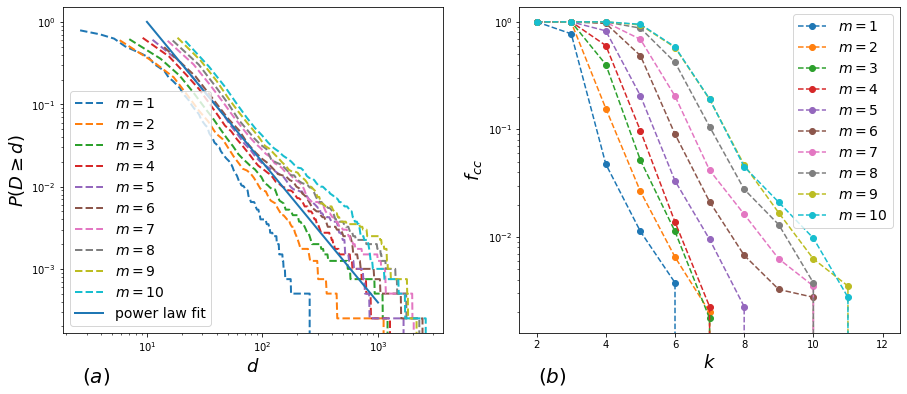

In [130]:
fig, ax = plt.subplots(nrows=1, sharex=False,sharey=False,ncols=2, figsize=(15, 6))

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_ylabel(r'$P(D\geq d)$', fontsize=18)
ax[0].set_xlabel(r'$d$', fontsize=18)

for i in range(len(graphs2)):
    y,x=np.histogram(degrees2[i],bins=200)
    x_=(x[1:]+x[:-1])/2
    ax[0].plot(x_,1-np.cumsum(y)/graphs2[i].number_of_nodes(),'--',linewidth=2,label=r'$m=$'+str(ms[i]))
    ax[1].plot(k_values,cliqs2[i],'o--',label=r'$m=$'+str(ms[i]))
    
x_=np.linspace(10,1000,100)
ax[0].plot(x_,np.exp(a*np.log(x_)+b),'-', linewidth=2, label='power law fit')
ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)


ax[1].set_yscale('log')
ax[1].set_ylabel(r'$f_{cc}$', fontsize=18)
ax[1].set_xlabel(r'$k$', fontsize=18)

ax[0].text(0.05, -0.1,  r'$ (a)$', transform=ax[0].transAxes,
            fontsize=20, fontweight='bold', va='top') 
ax[1].text(0.05, -0.1,  r'$ (b)$', transform=ax[1].transAxes,
            fontsize=20, fontweight='bold', va='top') 

#plt.savefig('figures\\fig-S02.pdf')